In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from scipy import misc
from sklearn.linear_model import Lasso, Ridge, LinearRegression
import torchvision.models as models

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load training data
Xtr_loadpath = 'Xtr.csv'
Xts_loadpath = 'Xts.csv'
ytr_loadpath = 'ytr.csv'

Xtr = np.loadtxt(Xtr_loadpath, delimiter=",")
Xts = np.loadtxt(Xts_loadpath, delimiter=",")
ytr = np.loadtxt(ytr_loadpath, delimiter=",")

In [3]:
# standardize the training data
Xtr_mean = np.mean(Xtr,axis=0)
Xtr_std = np.std(Xtr,axis=0)
ytr_mean = np.mean(ytr)
ytr_std = np.std(ytr)

Xtr_standardized = ((Xtr-Xtr_mean[None,:])/Xtr_std[None,:]) # revise this line as needed
Xts_standardized = ((Xts-Xtr_mean[None,:])/Xtr_std[None,:]) # revise this line as needed
ytr_standardized = ((ytr-ytr_mean)/ytr_std)

# save the standardized training data
Xtr_savepath = 'Xtr_pytorch.csv'
Xts_savepath = 'Xts_pytorch.csv'
ytr_savepath = 'ytr_pytorch.csv'
yts_hat_savepath = 'yts_hat_pytorch.csv'

np.savetxt(Xtr_savepath, Xtr_standardized, delimiter=",")
np.savetxt(Xts_savepath, Xts_standardized, delimiter=",")
np.savetxt(ytr_savepath, ytr_standardized, delimiter=",")

In [4]:
## Feature Selection
# The purpose of feature selection is not for the sake of itself,
# but for create a 5*5 “image-like” data set,
# for making the convolution more convinient.

lasso = Lasso()
lasso.set_params(alpha = 1e-4, max_iter=10000, tol=0.01, warm_start=True)
lasso.fit(Xtr_standardized,ytr)
print(lasso.coef_)
feature_selected = abs(lasso.coef_).argsort()[-25:][::-1]
print(feature_selected)

print(Xtr_standardized.shape)
print(Xts_standardized.shape)
Xtr_featSel = Xtr_standardized[:,feature_selected]
Xts_featSel = Xts_standardized[:,feature_selected]
print(Xtr_featSel.shape)
print(Xts_featSel.shape)

[-1.5267242  -0.91076686 -0.69006233  4.642815    0.2445895  -2.03472069
  5.0576172  -1.1295713   1.65090643  0.35562862 -1.00723549  5.60150115
  0.82607295 -1.70867092  0.31281437  0.15369499 -0.28580179 -0.05177723
  5.61939201 -4.21228062  1.69649358 -5.64370299  0.1223106   0.14070969
  0.06574903  1.7193156 ]
[21 18 11  6  3 19  5 25 13 20  8  0  7 10  1 12  2  9 14 16  4 15 23 22
 24]
(10000, 26)
(10000, 26)
(10000, 25)
(10000, 25)


In [5]:
batch_size = 100  # size of each batch
num_sample = Xtr_standardized.shape[0]
input_channels = 1
sequence_length = Xtr_standardized.shape[1]
kernel_size = 1

Xtr_featSel = Xts_featSel.reshape(num_sample, 5, 5)
Xts_featSel = Xts_featSel.reshape(num_sample, 5, 5)

print(str(Xts_featSel.shape))
print(str(Xts_featSel.shape))

(10000, 5, 5)
(10000, 5, 5)


In [6]:
# Convert the numpy arrays to PyTorch tensors
Xtr_torch = torch.Tensor(Xts_featSel)
ytr_torch = torch.Tensor(ytr)

# Create a training Dataset
train_ds = torch.utils.data.TensorDataset(Xtr_torch, ytr_torch)
# Creates a training DataLoader from this Dataset
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True) 

print(Xtr_torch.size(), ytr_torch.size())

torch.Size([10000, 5, 5]) torch.Size([10000])


In [13]:
nin = Xtr.shape[1]
nout = 1

# # model = nn.Sequential(
# #     nn.Linear(nin, 128*5),
# #     nn.ReLU(),
# #     nn.Dropout(p=0.5),  # Add dropout layer with probability 0.2
# #     nn.Linear(128*5, 64*5),
# #     nn.ReLU(),
# #     nn.Dropout(p=0.5),  # Add dropout layer with probability 0.2
# #     nn.Linear(64*5, 32*5),
# #     nn.ReLU(),
# #     nn.Dropout(p=0.5),  # Add dropout layer with probability 0.2
# #     nn.Linear(32*5, 16*5),
# #     nn.ReLU(),
# #     nn.Dropout(p=0.5),  # Add dropout layer with probability 0.2
# #     nn.Linear(16*5, 8*5),
# #     nn.ReLU(),
# #     nn.Linear(8*5, 4*5),
# #     nn.ReLU(),
# #     nn.Linear(4*5, 2*5),
# #     nn.ReLU(),
# #     nn.Linear(2*5, nout)
# # )

# model = nn.Sequential(
#     nn.Linear(nin, 2187),
#     nn.ReLU(),
#     nn.Dropout(p=0.5),  # Add dropout layer with probability 0.2
#     # nn.Linear(3788, 2187),
#     # nn.ReLU(),
#     # nn.Dropout(p=0.5),  # Add dropout layer with probability 0.2
#     nn.Linear(2187, 1262),
#     nn.ReLU(),
#     nn.Dropout(p=0.5),  # Add dropout layer with probability 0.2
#     nn.Linear(1262, 729),
#     nn.ReLU(),
#     nn.Dropout(p=0.5),  # Add dropout layer with probability 0.2
#     nn.Linear(729, 420),
#     nn.ReLU(),
#     nn.Dropout(p=0.5),  # Add dropout layer with probability 0.2   
#     nn.Linear(420, 243),
#     nn.ReLU(),
#     nn.Dropout(p=0.5),  # Add dropout layer with probability 0.2  
#     nn.Linear(243, 81),
#     nn.ReLU(),
#     nn.Dropout(p=0.5),  # Add dropout layer with probability 0.2
#     nn.Linear(81, 27),
#     nn.ReLU(),
#     nn.Linear(27, 9),
#     nn.ReLU(),
#     nn.Linear(9, 3),
#     nn.ReLU(),
#     nn.Linear(3, nout)
# )

class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=128, out_features=12)
        self.fc2 = nn.Linear(in_features=12, out_features=1)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(self.ReLU(self.conv1(x)))
        x = self.pool2(self.ReLU(self.conv2(x)))
        x = self.ReLU(self.conv3(x))
        x = self.ReLU(self.conv4(x))
        x = x.view(-1, 128)
        x = self.ReLU(self.fc1(x))
        x = self.fc2(x)
        return x

# cnnRregModel = nn.Sequential(
    
#     nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
#     nn.ReLU(),
#     nn.MaxPool1d(kernel_size=2),
    
#     nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
#     nn.ReLU(),
#     nn.MaxPool1d(kernel_size=2),
    
#     nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
#     nn.ReLU(),
#     nn.MaxPool1d(kernel_size=2),
    
#     nn.Linear(6400, 80),
#     nn.ReLU(),
#     nn.Dropout(p=0.5),  # Add dropout layer with probability 0.2
#     nn.Linear(80, nout),
# )

cnnRregModel = CNNRegressor()

print(str(cnnRregModel))

CNNRegressor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=1, bias=True)
  (ReLU): ReLU()
)


In [14]:
# Choosing the optimizer and loss function

epochs = 500
lrate = 2.5e-5
decay = lrate/epochs
lambda1 = lambda epoch: (1-decay)*epoch

opt = optim.Adam(cnnRregModel.parameters(), lr=lrate)
scheduler = optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)
criterion = nn.MSELoss()
#criterion = nn.HuberLoss(reduction='mean', delta=30)
#criterion = nn.L1Loss()

In [15]:
# training the model
num_epoch = epochs

a_tr_loss = np.zeros([num_epoch])
a_tr_Rsq = np.zeros([num_epoch])

for epoch in range(num_epoch):

    cnnRregModel.train() # put model in training mode
    batch_loss_tr = []
    batch_Rsq_tr = []
    # iterate over training set
    for train_iter, data in enumerate(train_loader):
        x_batch,y_batch = data
        y_batch = y_batch.view(-1,1)
        #y_batch = y_batch.type(torch.long)
        
        out = cnnRregModel(x_batch)
        # Compute Loss
        loss = criterion(out,y_batch.type(torch.float))
        batch_loss_tr.append(loss.item())
        # Compute R-square
        Rsq = r2_score(y_batch.type(torch.float).detach().numpy(), out.detach().numpy())
        batch_Rsq_tr.append(Rsq.item())
        # Compute gradients using back propagation
        opt.zero_grad()
        loss.backward()
        # Take an optimization 'step'
        opt.step()
        
    # Take scheduler step
    scheduler.step()
        
    a_tr_loss[epoch] = np.mean(batch_loss_tr) # Compute average loss over epoch
    a_tr_Rsq[epoch] = np.mean(batch_Rsq_tr)
    if (epoch+1) % 10 == 0:
        print('Epoch: {0:2d}   Train Loss: {1:.3f}   '.format(epoch+1, a_tr_loss[epoch])
             + 'R^2: {0:.3f}   '.format(a_tr_Rsq[epoch])
             )
    
with torch.no_grad():
    predict = cnnRregModel(torch.Tensor(Xtr_featSel)).detach().numpy().ravel()

r2 = r2_score(ytr,predict)
print('training R2: ',r2)
        

Epoch: 10   Train Loss: 100.978   R^2: -0.014   
Epoch: 20   Train Loss: 100.711   R^2: -0.011   
Epoch: 30   Train Loss: 99.665   R^2: 0.000   
Epoch: 40   Train Loss: 98.202   R^2: 0.013   
Epoch: 50   Train Loss: 96.952   R^2: 0.019   
Epoch: 60   Train Loss: 95.807   R^2: 0.033   
Epoch: 70   Train Loss: 93.535   R^2: 0.050   
Epoch: 80   Train Loss: 92.696   R^2: 0.052   
Epoch: 90   Train Loss: 91.211   R^2: 0.069   
Epoch: 100   Train Loss: 90.091   R^2: 0.088   
Epoch: 110   Train Loss: 89.702   R^2: 0.088   
Epoch: 120   Train Loss: 88.387   R^2: 0.081   
Epoch: 130   Train Loss: 88.182   R^2: 0.089   
Epoch: 140   Train Loss: 87.057   R^2: 0.103   
Epoch: 150   Train Loss: 86.877   R^2: 0.115   
Epoch: 160   Train Loss: 85.909   R^2: 0.114   
Epoch: 170   Train Loss: 83.978   R^2: 0.136   
Epoch: 180   Train Loss: 83.297   R^2: 0.145   
Epoch: 190   Train Loss: 82.892   R^2: 0.144   
Epoch: 200   Train Loss: 82.113   R^2: 0.153   
Epoch: 210   Train Loss: 85.347   R^2: 0.123 

Text(0, 0.5, 'Train accuracy')

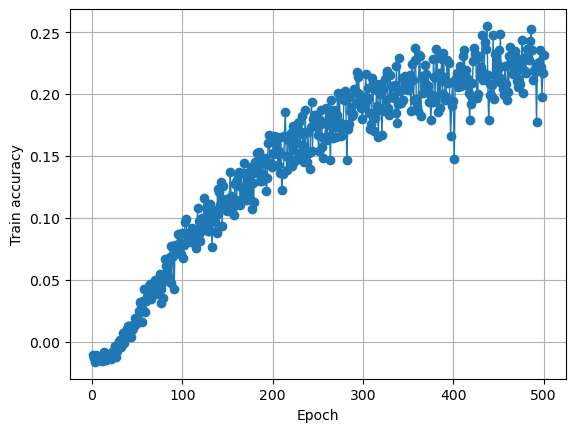

In [16]:
nepochs = len(a_tr_Rsq)
plt.plot(np.arange(1,nepochs+1), a_tr_Rsq, 'o-', linewidth=1)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Train accuracy')

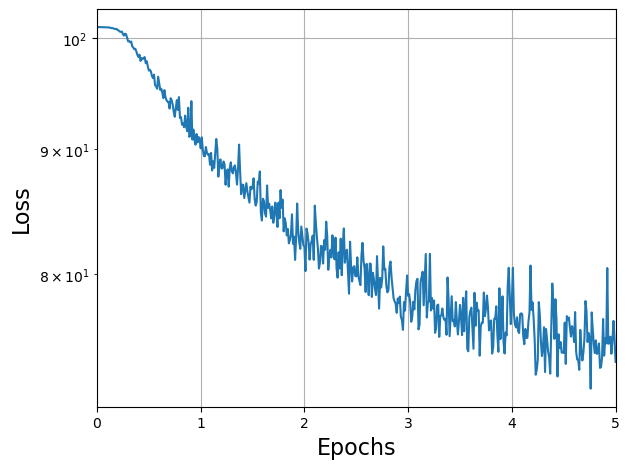

In [17]:
nsteps = len(a_tr_loss)
ntr = Xtr.shape[0]
epochs = np.arange(1,nsteps+1)*batch_size/ntr
plt.semilogy(epochs, a_tr_loss)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.grid()
plt.xlim([0,np.max(epochs)])
plt.tight_layout()

In [ ]:
np.savetxt(Xtr_savepath, Xtr_featSel, delimiter=",")
np.savetxt(Xts_savepath, Xts_featSel, delimiter=",")

In [ ]:
# save the model: you must use the .pth format for pytorch models!
model_savepath = 'model.pth'

# To save a PyTorch model, we first pass an input through the model, 
# and then save the "trace". 
# For this purpose, we can use any input. 
# We will create a random input with the proper dimension.
x = torch.randn(25) # random input
x = x[None,:] # add singleton batch index
with torch.no_grad():
    traced_cell = torch.jit.trace(cnnRregModel, (x))

# Now we save the trace
torch.jit.save(traced_cell, model_savepath)

In [ ]:
# generate kaggle submission file using the validation script
!python {"validation.py " + model_savepath + " --Xts_path " + Xts_savepath + " --Xtr_path " + Xtr_savepath + " --yts_hat_path " + yts_hat_savepath } 